<center>
  
# TABSYN: Tabular Data Synthesis with Diffusion Models

</center>

Two challenges regarding the extention of diffusion models to tabular data are:
1. **Diverse data types:** a single table can have different columns each containing data of different types, including numerical, categorical, text, etc.
2. **Varied distributions:** the distribution of data under different columns in a single table varry widely from column to column.

**TabSyn** addresses these challenges by introducing a latent space where tabular data of all columns are jointly represented. It then proceedes to train a diffusion model on the latent representations.
This tactic allows TabSyn to:
1. Train a single diffusion model for all data types in the dataset (i.e. Generality).
2. Optimize the distribution of latent embeddings to facilitate training of the subsequent diffusion model, thus generating higher quality synthetic data (i.e. Quality).
3. Require much fewer reverse steps during training of the diffusion model, and synthesize data faster (i.e. Speed).

In this notebook, we review and implement the TabSyn model. The notebook is organized as follows:

1. [Imports and Setup]()


2. [Default Dataset]()
    
    
3. [TabSyn Algorithm]()
    
    3.1. [Load Config]()
    
    3.2. [Make Dataset]()
    
    3.3. [Instantiate Model]()
    
    3.4. [Train Model]()
        
    3.5. [Load Pretrained Model]()
    
    3.6. [Sample Data]()
    
    3.7. [Review Synthetic Data]()


# Imports and Setup

In this section, we import all necessary libraries and modules required for setting up the environment.
Most of the libraries we need to implement TabSyn are the same as TabDDPM.
We also specify `NAME_URL_DICT_UCI`, `DATA_NAME`, `DATA_DIR` and other paths as in TabDDPM's implementation.


In [1]:
import json
import os
from pprint import pprint

import pandas as pd
import src
import torch
from scripts.download_dataset import download_from_uci
from scripts.process_dataset import process_data
from src.baselines.tabsyn.pipeline import TabSyn
from src.data import TabularDataset, preprocess
from src.util import visualize_default
from torch.utils.data import DataLoader


NAME_URL_DICT_UCI = {
    "adult": "https://archive.ics.uci.edu/static/public/2/adult.zip",
    "default": "https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip",
    "magic": "https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip",
    "shoppers": "https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip",
    "beijing": "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip",
    "news": "https://archive.ics.uci.edu/static/public/332/online+news+popularity.zip",
}

# For shared directory you can change it to "/projects/diffusion_bootcamp/data/tabular"
DATA_DIR = "data/"
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")
SYNTH_DATA_DIR = os.path.join(DATA_DIR, "synthetic_data")
DATA_NAME = "default"

MODEL_PATH = "models/tabsyn"

# Default Dataset

In this section, we will download the **Default of Credit Card Clients** dataset from the UCI repository and load it into a pandas DataFrame. This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. We will use this dataset to demonstrate the TabSyn method.
For more explanation of different steps in this section, please refer to TabDDPM's notebook.

In [3]:
# download data
download_from_uci(DATA_NAME, RAW_DATA_DIR, NAME_URL_DICT_UCI)

# process data
INFO_DIR = "data_info"
process_data(DATA_NAME, INFO_DIR, DATA_DIR)

# review data
df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, DATA_NAME, "train.csv"))
visualize_default(df).head(10)

Start processing dataset default from UCI.
Already downloaded.
Processing and Saving default Successfully!
Dataset Name: default
Total Size: 30000
Train Size: 27000
Test Size: 3000
Number of Numerical Columns: 14
Number of Categorical Columns: 10


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000.0,female,university,married,24.0,payment delay for three months,payment delay for three months,payment delay for one month,payment delay for one month,payment delay for one month,...,18457.0,21381.0,18914.0,0.0,1500.0,1600.0,1646.0,678.0,1000.0,1
1,200000.0,female,university,married,39.0,payment delay for four months,payment delay for three months,payment delay for three months,payment delay for three months,payment delay for three months,...,125357.0,121853.0,124731.0,0.0,6216.0,10000.0,0.0,5000.0,4552.0,1
2,230000.0,female,university,single,23.0,pay duly,pay duly,pay duly,pay duly,pay duly,...,1045.0,12525.0,12219.0,1444.0,14019.0,1045.0,12525.0,244.0,725.0,0
3,50000.0,female,graduate school,married,35.0,payment delay for one month,payment delay for one month,payment delay for one month,unknown,unknown,...,0.0,0.0,0.0,2400.0,0.0,0.0,0.0,0.0,0.0,0
4,160000.0,male,graduate school,married,39.0,unknown,unknown,unknown,unknown,unknown,...,0.0,2920.0,0.0,35.0,0.0,0.0,2920.0,0.0,12140.0,0
5,20000.0,male,high school,others,59.0,payment delay for three months,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,18055.0,18755.0,20299.0,1596.0,1600.0,1300.0,1000.0,2000.0,0.0,1
6,50000.0,male,university,single,42.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,17029.0,10575.0,9478.0,2500.0,2000.0,2500.0,500.0,500.0,500.0,0
7,130000.0,female,graduate school,single,26.0,payment delay for one month,pay duly,pay duly,pay duly,unknown,...,-884.0,-6332.0,-9333.0,1298.0,6730.0,900.0,5448.0,0.0,25000.0,0
8,300000.0,female,university,married,40.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,196467.0,201425.0,-8276.0,7028.0,6000.0,50000.0,10013.0,9505.0,175074.0,0
9,20000.0,male,university,married,27.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for four months,payment delay for three months,...,18472.0,18037.0,18487.0,3000.0,10000.0,0.0,0.0,900.0,2000.0,0


In [4]:
# review json file and its contents
with open(f"{PROCESSED_DATA_DIR}/{DATA_NAME}/info.json", "r") as file:
    data_info = json.load(file)
# pprint(data_info)

# TabSyn Algorithm

In this section, we will describe the design of TabSyn as well as its main hyperparameters loaded through config, which affect the model’s effectiveness. 

**TabSyn** consists of two parts:
1. A *variational auto-encoder (VAE)* which learns a joint representation space for the given tabular data.
2. A *Diffusion model* which learns the distribution of data in the joint representation space.

The figure below shows a diagram of the TabSyn model.

<p align="center">
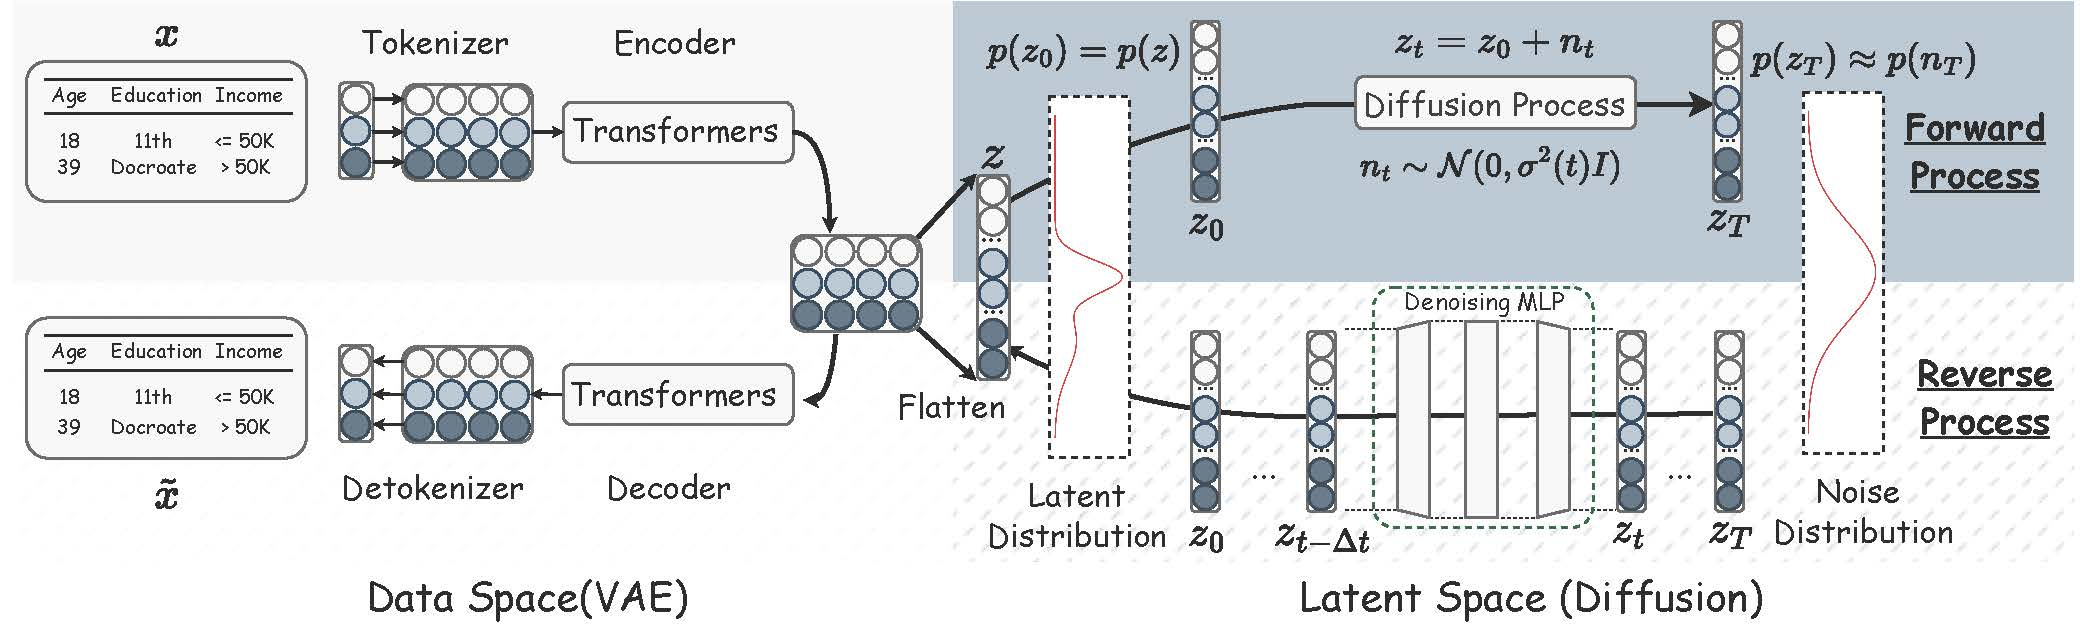
</p>

**VAE**

The left-side of the figure shows the VAE which operates in the original data space. The VAE itself consists of two parts: an encoder and a decoder. It also contains the corresponding tokenizer and detokenizer.
Each row of the input tabular data ($\pmb{x}$) is tokenized, then embedded by a transformer. Another transformer decodes the embeddings and a detokenizer reconstructs the table ($\pmb{\tilde{x}}$). The VAE is trained by minimizing the reconstruction loss between $\pmb{x}$ and $\pmb{\tilde{x}}$.

After the VAE is fully trained, the whole data ($\pmb{x}$) is tokenized and embedded. The embedding of each row is flattened to form a 1-dimensional vector $\pmb{z}$.
These 1-dimensional embeddings for all rows are stored on disk, and will later be used to train the diffusion model.

**Diffusion**

The right-side of the figure shows the diffusion model which operates in the latent representation space; in other words, it only *sees* the embeddings obtained by the VAE, not the original tabular data.
The diffusion model can be similarly divided into two parts: a forward process, and a reverse process.

The forward process receives the embedded data points. A single data point is denoted by $\pmb{z_0}$ in the figure. Gaussian noise is incrementally added to the embeddings in numerous incremental steps during the forward process. The number of the steps is denoted by $T$ in the figure. $T$ should be high enough that the distribution of embeddings at step $t=T$ is essentially a standard Gaussian distribution; in other words, the signal-to-noise ratio is practically zero.

The reverse process, on the other hand, learns to *predict* an earlier-step embedding (e.g. $\pmb{z_{t-\Delta t}}$) from a later-step embedding (e.g. $\pmb{z_t}$) via a neural network.

After the diffusion model is fully trained, the reverse process can estimate the data distribution at step $t=0$ if it receives a standard Gaussian distribution at step $t=T$. New data points can be synthesized by sampling from this estimated distribution.


## Load Config

In this section, we will load the configuration file that contains the hyperparameters for the TabSyn model. 

In [5]:
config_path = os.path.join("src/baselines/tabsyn/configs", f"{DATA_NAME}.toml")
raw_config = src.load_config(config_path)

pprint(raw_config)

{'impute': {'N': 20,
            'SIGMA_MAX': 80,
            'SIGMA_MIN': 0.002,
            'S_churn': 1,
            'S_max': inf,
            'S_min': 0,
            'S_noise': 1,
            'num_steps': 50,
            'num_trials': 50,
            'rho': 7},
 'loss_params': {'lambd': 0.7, 'max_beta': 0.01, 'min_beta': 1e-05},
 'model_params': {'d_token': 4, 'factor': 32, 'n_head': 1, 'num_layers': 2},
 'task_type': 'binclass',
 'train': {'diffusion': {'batch_size': 4096,
                         'num_dataset_workers': 4,
                         'num_epochs': 9},
           'optim': {'diffusion': {'factor': 0.9,
                                   'lr': 0.001,
                                   'patience': 20,
                                   'weight_decay': 0},
                     'vae': {'factor': 0.95,
                             'lr': 0.001,
                             'patience': 10,
                             'weight_decay': 0}},
           'vae': {'batch_size': 4096

The configuration file is a TOML file that contains the following hyperparameters:

1. **model_params:** specifies the structure of the transformers (both encoder and decoder) in the VAE model, including number of transformer layers, number of self-attnetion heads and token dimension.

2. **transforms:** specifies the transformations and preprocessing of the data before tokenization, such as cleaning, normalization, and encoding.
    - For preprocessing numerical features, we use the gaussian quantile transformation and replace the NaN values with mean of each row.
    - For categorical features, we use the one-hot encoding method. NaN values are left unchanged, but we have the option to replace them. We have the option to drop the values that appear with less than a given minimum frequency under each column. Furthermore, we have the option to add an extra encoding step for categorical features during tokenization.

3. **train.vae:** specifies training parameters of the VAE, including batch size, number of epochs, and number of dataset workers.

4. **train.diffusion:** specifies the same training parameters as above for the diffusion model.

5. **train.optim.vae:** specifies the parameters of the *Adam* optimizer and the `ReduceLROnPlateau` learning rate scheduler used to train the VAE. Optimizer parameters include initial learning rate and weight decay. LR scheduler parameters includer `factor` and `patience`.

6. **train.optim.diffusion:** specifies the same parameters as above for the diffusion model.

7. **loss_params:** specifies parameters of the loss function used to train the VAE including `max_beta`, `min_beta` and `lambd`.

$\beta$ is the coefficient of the KL divergence term in the VAE loss formula,

$\mathcal{L}_{vae} = \mathcal{L}_{mse} + \mathcal{L}_{ce} + \beta \mathcal{L}_{kl}$
.

Parameters `max_beta` and `min_beta` determine the range of $\beta$. $\beta$ is first set to `max_beta`. If the loss stops decreasing for a certain number of epochs (e.g. $10$ epochs), then at the end of each epoch after that (e.g. epoch $11$, $12$, etc.) $\beta$ is decreased by a factor of `lambd`,
$\beta_{new} = \lambda \beta_{curr}$,
until it reaches `beta_min`.


## Make Dataset

In this section, we pre-process the data and make a dataset object.

First, we determine transformations needed for the dataset, such as normalization and cleaning, in `transforms`. Next, using `preprocess` function we load the data from disk in arrays that contain both training and test data (`X_num` and `X_cat`), as well as the number of categories for each categorical feature (`categories`) and the number of numerical features (`d_numerical`).

We then separate the train and test data in different arrays and convert them to Pytorch tensors.
We create a dataset object (`TabularDataset`) with the train data. `TabularDataset` is a simple module which returns the tokens of a single row at a time. Each row constiutes a single data sample in TabSyn. Afterwards, we create a Dataloader for the train data using the `batch_size` and `num_workers` specified in config.

In contrast, we keep the test data as tensors (`X_test_num` and `X_test_cat`). If a GPU is available, we move these tensors to GPU so that they can be accessed by the model later on.

In [6]:
# preprocess data
X_num, X_cat, categories, d_numerical = preprocess(
    os.path.join(PROCESSED_DATA_DIR, DATA_NAME),
    transforms=raw_config["transforms"],
    task_type=raw_config["task_type"],
)

# separate train and test data
X_train_num, X_test_num = X_num
X_train_cat, X_test_cat = X_cat

# convert to float tensor
X_train_num, X_test_num = (
    torch.tensor(X_train_num).float(),
    torch.tensor(X_test_num).float(),
)
X_train_cat, X_test_cat = torch.tensor(X_train_cat), torch.tensor(X_test_cat)

# create dataset module
train_data = TabularDataset(X_train_num.float(), X_train_cat)

# move test data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_num = X_test_num.float().to(device)
X_test_cat = X_test_cat.to(device)

# create train dataloader
train_loader = DataLoader(
    train_data,
    batch_size=raw_config["train"]["vae"]["batch_size"],
    shuffle=True,
    num_workers=raw_config["train"]["vae"]["num_dataset_workers"],
)

No NaNs in numerical features, skipping


## Instantiate Model

Next, we instantiate the model using the `TabSyn` class. `TabSyn` class takes the following arguments:

1. `train_loader`: dataloader for train data.
2. `X_test_num`: numerical features of the test data.
3. `X_test_cat`: categorical features of the train data.
4. `num_numerical_features`: number of numerical features in the dataset.
5. `num_classes`: number of classes (i.e. categories) of each categorical feature in the dataset.
6. `device`: the device on which the model and data exist, either "cpu" or "cuda".

In [7]:
tabsyn = TabSyn(
    train_loader,
    X_test_num,
    X_test_cat,
    num_numerical_features=d_numerical,
    num_classes=categories,
    device=device,
)

`TabSyn` class has the tools to instantiate VAE and diffusion models, train both, and sample from the trained diffusion model.
We will demonstrate how to use these tools in the following sections.

## Train Model


The VAE and the diffusion model are trained independently. The following subsections explain each training process.


### A. Train VAE

First, we need to instantiate the VAE using the `instantiate_vae` method. This method takes the VAE model hyperparameters, optimizer and lr scheduler parameters from config, and instantiates them.

In [9]:
# instantiate VAE model for training
tabsyn.instantiate_vae(
    **raw_config["model_params"], optim_params=raw_config["train"]["optim"]["vae"]
)

self.category_embeddings.weight.shape=torch.Size([79, 4])
self.category_embeddings.weight.shape=torch.Size([79, 4])
Successfully instantiated VAE model.


Now that we have instantiated the VAE, we can train it using the `train_vae` function.
This function receives the loss hyperparameters and number of epochs from the config.
Moreover, it recieves `save_path` which is the directory where trained model checkpoints will be saved.

In [83]:
os.makedirs(f"{MODEL_PATH}/{DATA_NAME}/vae")
tabsyn.train_vae(
    **raw_config["loss_params"],
    num_epochs=raw_config["train"]["vae"]["num_epochs"],
    save_path=os.path.join(MODEL_PATH, DATA_NAME, "vae"),
)

Epoch 1/10: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


epoch: 0, beta = 0.010000, Train MSE: 13.663756, Train CE:2.154334, Train KL:0.945002, Val MSE:12.495003, Val CE:2.104598, Train ACC:0.280852, Val ACC:0.286902


Epoch 2/10: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch: 1, beta = 0.010000, Train MSE: 12.019743, Train CE:2.083766, Train KL:1.020754, Val MSE:11.045834, Val CE:2.061779, Train ACC:0.296256, Val ACC:0.301399


Epoch 3/10: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


epoch: 2, beta = 0.010000, Train MSE: 10.634787, Train CE:2.044676, Train KL:1.146477, Val MSE:9.823824, Val CE:2.036949, Train ACC:0.304690, Val ACC:0.300689


Epoch 4/10: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


epoch: 3, beta = 0.010000, Train MSE: 9.484139, Train CE:2.034360, Train KL:1.300207, Val MSE:8.833112, Val CE:2.014092, Train ACC:0.311833, Val ACC:0.318329


Epoch 5/10: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch: 4, beta = 0.010000, Train MSE: 8.459760, Train CE:2.017638, Train KL:1.464170, Val MSE:7.862492, Val CE:1.994941, Train ACC:0.337866, Val ACC:0.348642


Epoch 6/10: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch: 5, beta = 0.010000, Train MSE: 7.611962, Train CE:1.999599, Train KL:1.626225, Val MSE:7.053391, Val CE:1.986582, Train ACC:0.383262, Val ACC:0.402778


Epoch 7/10: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch: 6, beta = 0.010000, Train MSE: 6.869578, Train CE:1.979303, Train KL:1.785650, Val MSE:6.403675, Val CE:1.964470, Train ACC:0.437565, Val ACC:0.456103


Epoch 8/10: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


epoch: 7, beta = 0.010000, Train MSE: 6.204691, Train CE:1.968276, Train KL:1.947868, Val MSE:5.838765, Val CE:1.956694, Train ACC:0.476162, Val ACC:0.486922


Epoch 9/10: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch: 8, beta = 0.010000, Train MSE: 5.646989, Train CE:1.966729, Train KL:2.115103, Val MSE:5.310214, Val CE:1.970527, Train ACC:0.499656, Val ACC:0.497972


Epoch 10/10: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

epoch: 9, beta = 0.010000, Train MSE: 5.151427, Train CE:1.979931, Train KL:2.282740, Val MSE:4.881950, Val CE:1.979485, Train ACC:0.497676, Val ACC:0.498581
Training time: 0.1025 mins
Successfully trained and saved the VAE model!


After training the VAE, we embed the training data with the trained encoder and store the embeddings in a direcotry specified by `vae_ckpt_dir`.

In [84]:
# embed all inputs in the latent space
tabsyn.save_vae_embeddings(
    X_train_num, X_train_cat, vae_ckpt_dir=os.path.join(MODEL_PATH, DATA_NAME, "vae")
)

Successfully saved pretrained embeddings on disk!


### B. Train Diffusion Model

Now that we have stored the training data embeddings, we need to load and prepare them for the diffusion model.
We load the embeddings using `load_vae_embeddings`. We normalize the embeddings by subtracting the mean and dividing by the standard deviation. Then, we create a Dataloader with the specified `batch_size` and `num_workers` from the config.

In [10]:
# load latent space embeddings
train_z, _ = tabsyn.load_latent_embeddings(
    os.path.join(MODEL_PATH, DATA_NAME, "vae")
)  # train_z dim: B x in_dim

# normalize embeddings
mean, std = train_z.mean(0), train_z.std(0)
latent_train_data = (train_z - mean) / 2

# create data loader
latent_train_loader = DataLoader(
    latent_train_data,
    batch_size=raw_config["train"]["diffusion"]["batch_size"],
    shuffle=True,
    num_workers=raw_config["train"]["diffusion"]["num_dataset_workers"],
)

Now that the data is ready, we instantiate the diffusion model with `instantiate_diffusion`. The input dimension and hidden dimention of the diffusion model is determined by the dimension of the embeddings. 
Moreover, we instantiate the optimizer and lr scheduler using hyperparameters from config.

In [11]:
# instantiate diffusion model for training
tabsyn.instantiate_diffusion(
    in_dim=train_z.shape[1],
    hid_dim=train_z.shape[1],
    optim_params=raw_config["train"]["optim"]["diffusion"],
)

MLPDiffusion(
  (proj): Linear(in_features=96, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=96, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
The number of parameters: 10690656
Successfully instantiated diffusion model.


We train the diffusion model with `train_diffusion` function.
This function takes the following arguements:
1. `latent_train_loader`: dataloader for the latent representations which are used to train the diffusion model.
2. `num_epochs`: number of training epochs.
3. `ckpt_path`: directory where the model checkpoints will be stored.

In [87]:
os.makedirs(f"{MODEL_PATH}/{DATA_NAME}")
# train diffusion model
tabsyn.train_diffusion(
    latent_train_loader,
    num_epochs=raw_config["train"]["diffusion"]["num_epochs"],
    ckpt_path=os.path.join(MODEL_PATH, DATA_NAME),
)

Epoch 9/9: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s, Loss=1.14]


Time:  5.782466650009155


## Load Pretrained Model

Instead of training model from scratch, we can also load weights of a pre-trained model from a given checkpoint with `load_model_state` function.
If we haven't instantiated the VAE and diffusion model beforehand, we need to instantiate them first using `instantiate_vae` and `instantiate_diffusion` methods.

In [11]:
# instantiate VAE model
tabsyn.instantiate_vae(**raw_config["model_params"], optim_params=None)

latent_embeddings_path = (
    "/projects/diffusion_bootcamp/models/tabular/tabsyn/default/vae"
)
# load latent embeddings of input data
train_z, token_dim = tabsyn.load_latent_embeddings(latent_embeddings_path)

# instantiate diffusion model
tabsyn.instantiate_diffusion(
    in_dim=train_z.shape[1], hid_dim=train_z.shape[1], optim_params=None
)

pretrained_model_path = "/projects/diffusion_bootcamp/models/tabular/tabsyn/default"
# load state from checkpoint
tabsyn.load_model_state(ckpt_dir=pretrained_model_path, dif_ckpt_name="model.pt")

Successfully instantiated VAE model.
MLPDiffusion(
  (proj): Linear(in_features=96, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=96, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
The number of parameters: 10690656
Successfully instantiated diffusion model.
Loaded model state from /projects/diffusion_bootcamp/models/tabular/tabsyn/default_2


## Sample Data

Now that we trained the model effectively, using `sample` function we can generate synthetic data starting from compelete noise. The input of this function is as follows:

1. `train_z`: latent embeddings of the training data.
2. `info`: info about the data from the json file we reviewed at the beginning of this notebook.
3. `num_inverse`: detokenizer for numerical features.
4. `cat_inverse`: detokenizer for categorical features.
5. `save_path`: file-path where the synthetic table will be saved.

In [12]:
# load data info file
with open(os.path.join(PROCESSED_DATA_DIR, DATA_NAME, "info.json"), "r") as file:
    data_info = json.load(file)
data_info["token_dim"] = token_dim

# get inverse tokenizers
_, _, categories, d_numerical, num_inverse, cat_inverse = preprocess(
    os.path.join(PROCESSED_DATA_DIR, DATA_NAME),
    transforms=raw_config["transforms"],
    task_type=raw_config["task_type"],
    inverse=True,
)

# sample data
num_samples = train_z.shape[0]
in_dim = train_z.shape[1]
mean_input_emb = train_z.mean(0)
tabsyn.sample(
    num_samples,
    in_dim,
    mean_input_emb,
    info=data_info,
    num_inverse=num_inverse,
    cat_inverse=cat_inverse,
    save_path=os.path.join(SYNTH_DATA_DIR, DATA_NAME, "tabsyn.csv"),
)

No NaNs in numerical features, skipping
(27000, 10)
Time: 13.619803667068481
Saving sampled data to data/synthetic_data/default/tabsyn.csv


## Review Synthetic Data

Finally here, we review the synthesized data. In the following `evaluate_synthetic_data.ipynb` notebook, we will evaluate this synthesized data with respect to various metrics.

In [4]:
df = pd.read_csv(os.path.join(SYNTH_DATA_DIR, DATA_NAME, "tabsyn.csv"))

# Display the first few rows of the DataFrame
visualize_default(df).head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,70000.0,female,university,married,46.0,payment delay for two months,unknown,unknown,unknown,unknown,...,0.0000,0.0000,426.36752,0.00000,0.0000,0.00000,0.00000,390.00000,0.00000,1
1,500000.0,female,university,married,42.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,38604.0400,29854.2970,8425.42000,8114.09130,3335.9043,1719.04970,1198.85100,1955.60230,3629.17190,0
2,50000.0,female,high school,married,23.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,10154.2210,11260.9220,10000.80800,1198.67710,1400.0000,998.12720,733.49927,0.00000,357.53696,0
3,240000.0,female,high school,married,53.0,payment delay for four months,payment delay for three months,payment delay for one month,payment delay for one month,payment delay for one month,...,178097.2800,167049.8800,171107.90000,0.00000,14097.7300,8849.46100,6000.00000,6702.95400,10032.20900,0
4,120000.0,male,university,married,32.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,81177.9600,76788.4300,79741.32000,3098.13750,4879.0130,4000.00000,3470.72490,5000.00000,2761.03880,0
5,210000.0,male,university,single,27.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,17803.7900,18270.0660,8776.32100,1607.79960,1592.6553,397.29932,1031.17900,645.88776,599.63580,0
6,130000.0,female,graduate school,single,28.0,payment delay for two months,payment delay for three months,payment delay for one month,payment delay for one month,payment delay for one month,...,4084.5452,1196.6735,0.00000,406.65112,2283.2983,0.00000,0.00000,0.00000,0.00000,1
7,240000.0,female,graduate school,single,27.0,payment delay for one month,payment delay for one month,payment delay for one month,unknown,unknown,...,0.0000,0.0000,0.00000,393.83884,0.0000,0.00000,0.00000,0.00000,0.00000,0
8,250000.0,female,high school,single,29.0,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,payment delay for one month,...,160703.2700,257110.9700,154884.60000,132673.27000,30015.8710,11078.56100,108035.09000,6004.35200,5054.99500,0
9,70000.0,female,university,married,47.0,payment delay for two months,payment delay for three months,payment delay for one month,payment delay for one month,payment delay for one month,...,70747.6000,29295.8930,29157.73000,0.00000,3000.0000,3000.00000,1018.06110,1000.00000,1500.00000,0


## References

**Zhang, Hengrui, et al.** "Mixed-type tabular data synthesis with score-based diffusion in latent space." *International Conference on Learning Representations (ICLR)* (2023).

**GitHub Repository:** [Amazon Science - Tabsyn](https://github.com/amazon-science/tabsyn)